## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix, kron
from scipy.linalg import sqrtm
from scipy.special import gamma, factorial, legendre, lpmv, lpmn
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
def Sph_vec_coordinates(m, n):
    theta0, phi0 = np.linspace(0, np.pi, m), np.linspace(0, 2*np.pi, n, endpoint=False)
    theta, phi = np.meshgrid(theta0, phi0)
    theta, phi = theta.flatten(), phi.flatten()
    sph_vec = np.zeros((len(theta), 2))
    sph_vec[:,0], sph_vec[:,1] = theta, phi
    return sph_vec

def Sph_cart_coordinates(sph_vec):
    theta, phi = sph_vec[:,0], sph_vec[:,1]
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z

def geo_dist(x1, y1, z1, x2, y2, z2):
    geo_d = np.arccos(np.round(x1*x2 + y1*y2 +z1*z2, 15))
    return geo_d

def Sph_cov(x, y, z, H, n, m, c_h):
    cov = np.zeros((m, n*m))
    for i in range(m):
        cov[i, :] = ((2*np.pi)**(2*H))*(1- c_h*(geo_dist(x[i], y[i], z[i], x, y, z))**(2*H))
    return cov

def fourier_mat(n):
    F = np.zeros((n, n), dtype=np.complex)
    for i in range(n):
        for j in range(n):
            F[i, j] = np.exp(-2*np.pi*1j/n)**(i*j)
    return F

def diagonal_lamda(lamda, n, m):
    diag_lamda = lil_matrix((n*m, n*m), dtype=np.complex)
    for i in range(n):
        diag_lamda[(i*m):(i+1)*m, (i*m):(i+1)*m] = sqrtm(lamda[:,(i*m):(i+1)*m])
    return diag_lamda

def Sph_fBm(m, n, H):
    sph_vec = Sph_vec_coordinates(m, n)
    c_h = 0.5*(2/np.pi)**(2*H)
    x, y, z = Sph_cart_coordinates(sph_vec=sph_vec)
    cov = Sph_cov(x, y, z, H, n, m, c_h)
    F = fourier_mat(n)
    F_I = kron(csr_matrix(F), csr_matrix(np.diag(np.ones(m))))
    lamda = csr_matrix(cov).dot(F_I).todense()
    diag_lamda = diagonal_lamda(lamda, n, m)
    Z = np.random.normal(0,1,n*m) + 1j*np.random.normal(0,1,n*m)
    diag_lamda_Z = csr_matrix(diag_lamda).dot(csr_matrix(Z).T)
    X = np.real(F_I.dot(diag_lamda_Z).todense())/np.sqrt(n)
    Y1 = np.array(X).reshape(m*n)
    return Y1, sph_vec

In [3]:
def Sph_counting(XX,YY,ZZ,X,Y,Z):
    count = np.sum((np.outer(X,XX) + np.outer(Y,YY) + np.outer(Z,ZZ)>0), axis = 1)
    return count % 2

def Sph_random_coordinates(n):
    theta = np.arccos(np.random.uniform(-1, 1, n))
    phi = np.random.uniform(0, 2*np.pi, n)
    xx = np.sin(theta)*np.cos(phi)
    yy = np.sin(theta)*np.sin(phi)
    zz = np.cos(theta)
    return xx, yy, zz

def Sph_one_oov(beta, sph_vec):
    ga_1, ga_beta, ga_1beta = np.random.gamma(1, 1, 1), np.random.gamma(beta, 1, 1), np.random.gamma(1-beta, 1, 1)
    Lambda = ga_1*ga_1beta/ga_beta
    Q_beta = 1 + np.random.poisson(Lambda, 1)
    if (beta <= 0.5):
        Q_beta[Q_beta > 10000] = 10000
    x, y, z = Sph_cart_coordinates(sph_vec)
    xx, yy, zz = Sph_random_coordinates(Q_beta)
    count1 = Sph_counting(xx,yy,zz,x,y,z)
    #count2 = Sph_counting(np.zeros(len(xx)), np.zeros(len(yy)), zz, np.zeros(len(x)), np.zeros(len(y)), np.ones(len(z)))[0]
    return count1 #count2 

def Sph_large_jump(N, alpha, beta, sph_vec, epsilon):
    n = sph_vec.shape[0]
    D = np.zeros((n, N))
    for i in range(0, N):
        D[:, i] = Sph_one_oov(beta, sph_vec)
    U = np.random.uniform(0, 1, N)
    V = np.random.choice([-1, 1], N, replace=True, p=[0.5, 0.5])*(epsilon/(U**(1/alpha)))
    Y2 = np.sum(D*V, axis=1) #np.sum(D2*V)
    return Y2

def Sph_KSP(alpha, beta, m, n):
    if alpha == 1:
        C_alpha = np.pi/2
    else:
        C_alpha = (1-alpha)/(gamma(2-alpha)*np.cos(np.pi*alpha/2))
    if alpha >= 1:
        epsilon = (0.01*(3-alpha)*np.sqrt(alpha*C_alpha)/(2-alpha)**(3/2))**(2/alpha)     # error from B-E < 0.01
    else:
        epsilon = 0.0001
    sigma_epsilon = (np.sqrt(alpha*C_alpha/(2-alpha))**(1/2))*epsilon**(1-alpha/2)
    nu_epsilon = 2**(1-beta)*(4*np.pi)**(beta)*C_alpha*epsilon**(-alpha)
    N = int(np.random.poisson(nu_epsilon, 1))  
    Y1, sph_vec = Sph_fBm(m, n, beta/2)
    Y1 = sigma_epsilon*Y1
    Y2 = Sph_large_jump(N, alpha, beta, sph_vec, epsilon)
    Y = Y1 + Y2
    return Y1, Y2, Y

In [4]:
##YZ's functions

import numpy as np
import matplotlib.pyplot as plt


## I keep this function here only for sampling from OOV. To be depreciated.
def Sph_coordinates_new(n):
    #theta = np.arccos(np.linspace(-1, 1, n+1))
    theta = (np.linspace(0, np.pi, n))
    phi = np.linspace(0, 2*np.pi, n,endpoint=False)
    theta,phi = np.meshgrid(theta,phi)
    theta,phi = theta.flatten(),phi.flatten()
    
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z, theta, phi

## theta,phi\in [0,pi]*[0,2pi)

## YZ: all the sampling functions should take argument sph_vec as a vector of polar coordiates 
## (instead of theta,phi as two separate vectors of the same size), 
## as the following function
def Sph_coordinates_vec(n):
    #theta = np.arccos(np.linspace(-1, 1, n+1))
    theta = (np.linspace(0, np.pi, n))
    phi = np.linspace(0, 2*np.pi, n,endpoint=False)
    theta,phi = np.meshgrid(theta,phi)
    theta,phi = theta.flatten(),phi.flatten()

    sph_vec = np.zeros((n,2))
    sph_vec[:,0] = theta
    sph_vec[:,1] = phi
    
    return sph_vec

## translate bewteen cartesian and spherical (polar) coordinates.
def cart2sph_vec(cart_vec):
    not_a_sequence = False
    if cart_vec.shape == (2,): 
        not_a_sequence = True
        cart_vec = cart_vec.reshape(1,2)
        
    n = cart_vec[:,0].size
    dxy = np.sqrt(cart_vec[:,0]**2 + cart_vec[:,1]**2)
    
    phi_vec = np.zeros((n,2))
    phi_vec[:,1] = np.arctan2(cart_vec[:,1], cart_vec[:,0])
    phi_vec[:,0] = np.pi/2 - np.arctan2(cart_vec[:,2], dxy)

    if not_a_sequence == True: return phi_vec[0,:]
    return phi_vec
   
def sph2cart_vec(sph_vec):
    not_a_sequence = False
    if sph_vec.shape == (2,): 
        not_a_sequence = True
        sph_vec = sph_vec.reshape(1,2)
        
    n = sph_vec[:,0].size
    cart_vec = np.zeros((n,3))
    cart_vec[:,2] = np.cos(sph_vec[:,0])
    rsintheta = np.sin(sph_vec[:,0])
    cart_vec[:,0] = rsintheta * np.cos(sph_vec[:,1])
    cart_vec[:,1] = rsintheta * np.sin(sph_vec[:,1])

    if not_a_sequence == True: return cart_vec[0,:]
    return cart_vec
    
def geo_dist_vec(sph_v1,sph_v2):
    return np.arccos(np.cos(sph_v1[:,0])*np.cos(sph_v2[:,0])+np.sin(sph_v1[:,0])*np.sin(sph_v2[:,0])*np.cos(sph_v1[:,1]-sph_v2[:,0]))


## check out axis-angle representation of 3d rotation
## https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation#Rotation_vector
## and scipy packages
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.apply.html#scipy.spatial.transform.Rotation.apply
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_rotvec.html#scipy.spatial.transform.Rotation.from_rotvec
## so basically, rotate the north pole to the point represented by theta0, phi0
## the rotation axis is outer(north pole, (theta0,phi0))
## and the angle is inner(north pole, (theta0,phi0)

from scipy.interpolate import griddata
from scipy.spatial.transform import Rotation

#new_NP_sph in spherical coordinate
def rotate_NP(sph_v,new_NP_sph):
    if new_NP_sph[0] == 0: return sph_v
    
    new_NP_cart = sph2cart_vec(new_NP_sph)
    angle = np.arccos(np.dot(new_NP_cart,[0,0,1]))
    axis = np.cross(new_NP_cart,[0,0,1])/np.sin(angle)
    r = Rotation.from_rotvec(angle * axis)

    cart_v = sph2cart_vec(sph_v)                 
    sph_v_rotated = cart2sph_vec(r.apply(cart_v))
    return sph_v_rotated

def rotate_NP_inv(sph_v,new_NP_sph):
    if new_NP_sph[0] == 0: return sph_v
    
    new_NP_cart = sph2cart_vec(new_NP_sph)
    angle = np.arccos(np.dot(new_NP_cart,[0,0,1]))
    axis = np.cross(new_NP_cart,[0,0,1])/np.sin(angle)
    r = Rotation.from_rotvec(angle * axis)
    r = r.inv()

    cart_v = sph2cart_vec(sph_v)                 
    sph_v_rotated = cart2sph_vec(r.apply(cart_v))
    return sph_v_rotated


def polar2hemisphere(nn,X,sph_v, method = 'cubic'):
    
    NP = np.array([0,0]).reshape(1,2)
    xi, yi = np.meshgrid(np.linspace(-1,1, nn),np.linspace(-1,1, nn))
    ind_hemi = np.asarray(geo_dist_vec(sph_v,NP) <np.pi/2).nonzero()[0]
    cart_v = sph2cart_vec(sph_v[ind_hemi,:])
    ## method = 'cubic', 'nearest', 'linear'
    zi = griddata(cart_v[:,[0,1]], X[ind_hemi], (xi, yi), method='cubic')
    return xi,yi,zi

def hemisphere_select(sph_v, X):    
    NP = np.array([0,0]).reshape(1,2)
    ind_hemi = np.where(geo_dist_vec(sph_v,NP) <np.pi/2)[0]
    return sph_v[ind_hemi,:],X[ind_hemi]


def great_circle(n,NP):
    sph_v = np.zeros((n+1,2))
    sph_v[:,0] = np.pi/2
    sph_v[:,1] = np.linspace(0,np.pi*2,n+1,endpoint = True)
    return rotate_NP_inv(sph_v,NP)



def great_circle_in_hemi(n,NP):
    sph_v = great_circle(n,NP)
    NP0 = np.array([0,0]).reshape(1,2)
    ind_hemi = np.where(geo_dist_vec(sph_v,NP0) <np.pi/2)[0]
    sph_v = sph_v[ind_hemi,:]
    cart_v = sph2cart_vec(sph_v)
    diff_v = np.diff(cart_v[:,0])**2+np.diff(cart_v[:,1])**2
    #find where is the largest gap (where the great_circle has a "gap" in the hemisphere)

    max_ind = np.argmax(diff_v)
    diff_value1 = diff_v[max_ind]
    ll = sph_v[:,0].size
    diff_value2 = (cart_v[0,0]-cart_v[ll-1,0])** 2 + (cart_v[0,1]-cart_v[ll-1,1])**2

    if diff_value1 > diff_value2: 
        sph_new = np.concatenate((sph_v[(max_ind+1):,:],sph_v[0:(max_ind-1),:]))
    else: sph_new = sph_v

    return sph_new
    

## Plot

In [33]:
## Plots of large-jump, small-jump and combined part

m = 300
n = 150
nn = 300
alpha = 1.2
beta = 0.5

## Simulate the large-jump, small-jump and combined part
sph_vec = Sph_vec_coordinates(m, n)
x, y, z = Sph_cart_coordinates(sph_vec)

Y1, Y2, Y = Sph_KSP(alpha, beta, m, n)

## rotate options
#new_NP_sph = np.array([np.pi/6,0])
#new_NP_sph2 = np.array([np.pi/4,0])
#xi1,yi1,zi1 = polar2hemisphere(nn,Y1,rotate_NP(sph_vec,new_NP_sph))
#xi2,yi2,zi2 = polar2hemisphere(nn,Y2,rotate_NP(sph_vec,new_NP_sph))
#xi3,yi3,zi3 = polar2hemisphere(nn,Y,rotate_NP(sph_vec,new_NP_sph))


xi1, yi1, zi1 = polar2hemisphere(nn, Y1, sph_vec)
xi2, yi2, zi2 = polar2hemisphere(nn, Y2, sph_vec)
xi3, yi3, zi3 = polar2hemisphere(nn, Y, sph_vec)

TT = np.linspace(0,2*np.pi,n)
XX,YY = np.cos(TT),np.sin(TT)


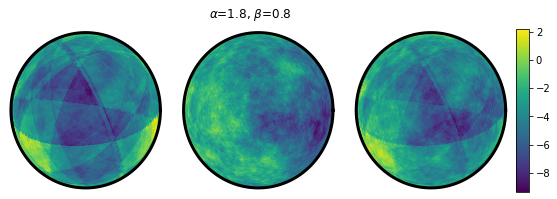

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.1)

axs[0].pcolormesh(xi2,yi2,zi2,cmap = "viridis",rasterized=True)
axs[0].plot(XX,YY,color = "black", linewidth = 3)
axs[0].set_xlim([-1.05, 1.05])
axs[0].set_ylim([-1.05, 1.05])
axs[0].axis('off')

axs[1].pcolormesh(xi1,yi1,zi1,cmap = "viridis",rasterized=True)
axs[1].plot(XX,YY,color = "black", linewidth = 3)
axs[1].set_xlim([-1.05, 1.05])
axs[1].set_ylim([-1.05, 1.05])
axs[1].axis('off')

im = axs[2].pcolormesh(xi3,yi3,zi3,cmap = "viridis",rasterized=True)
axs[2].plot(XX,YY,color = "black", linewidth = 3)
axs[2].set_xlim([-1.05, 1.05])
axs[2].set_ylim([-1.05, 1.05])
axs[2].axis('off')

cax = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
plt.colorbar(im, cax=cax) 

fig.suptitle(r"$\alpha$=" + str(alpha) + r", $\beta$=" + str(beta))
plt.savefig('sfLC_alpha'+str(alpha)+'_beta'+str(beta)+'.pdf', bbox_inches = 'tight')


plt.show()

## 4 plots

In [5]:
m = 300
n = 150
nn = 300

sph_vec = Sph_vec_coordinates(m, n)
x, y, z = Sph_cart_coordinates(sph_vec)

In [6]:
alpha = 1.2
beta = 0.5

Y1, Y2, Y = Sph_KSP(alpha, beta, m, n)

xi11, yi11, zi11 = polar2hemisphere(nn, Y1, sph_vec)
xi21, yi21, zi21 = polar2hemisphere(nn, Y2, sph_vec)
xi31, yi31, zi31 = polar2hemisphere(nn, Y, sph_vec)

In [7]:
alpha = 1.2
beta = 0.8

Y1, Y2, Y = Sph_KSP(alpha, beta, m, n)

xi12, yi12, zi12 = polar2hemisphere(nn, Y1, sph_vec)
xi22, yi22, zi22 = polar2hemisphere(nn, Y2, sph_vec)
xi32, yi32, zi32 = polar2hemisphere(nn, Y, sph_vec)

In [8]:
alpha = 1.8
beta = 0.5

Y1, Y2, Y = Sph_KSP(alpha, beta, m, n)

xi13, yi13, zi13 = polar2hemisphere(nn, Y1, sph_vec)
xi23, yi23, zi23 = polar2hemisphere(nn, Y2, sph_vec)
xi33, yi33, zi33 = polar2hemisphere(nn, Y, sph_vec)

In [9]:
alpha = 1.8
beta = 0.8

Y1, Y2, Y = Sph_KSP(alpha, beta, m, n)

xi14, yi14, zi14 = polar2hemisphere(nn, Y1, sph_vec)
xi24, yi24, zi24 = polar2hemisphere(nn, Y2, sph_vec)
xi34, yi34, zi34 = polar2hemisphere(nn, Y, sph_vec)

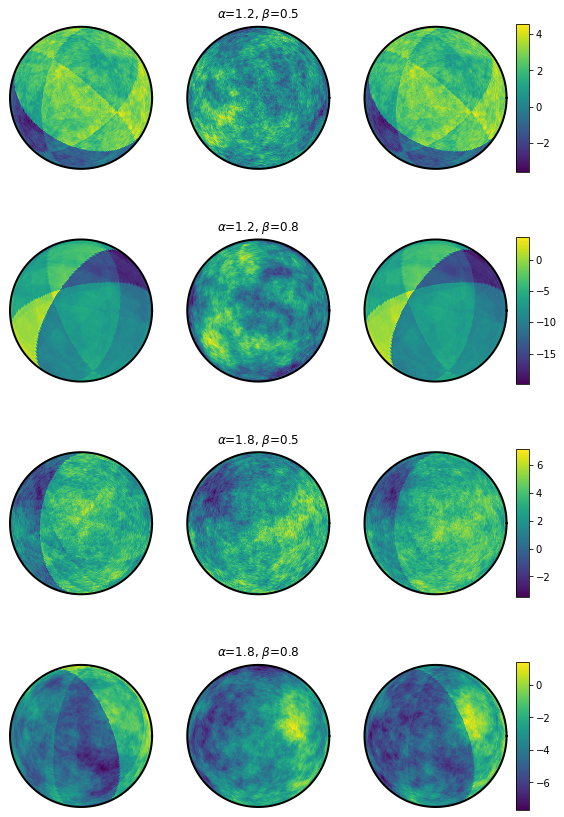

In [11]:
TT = np.linspace(0,2*np.pi,n)
#XX,YY = np.cos(TT),np.sin(TT)
R = 1.01
XX,YY = R*np.cos(TT),R*np.sin(TT)

fig, axs = plt.subplots(4, 3, figsize=(9, 15), sharey=True)

axs[0,0].pcolormesh(xi21,yi21,zi21,cmap = "viridis",rasterized=True)
axs[0,0].plot(XX,YY,color = "black", linewidth = 2)
axs[0,0].set_xlim([-1.05, 1.05])
axs[0,0].set_ylim([-1.05, 1.05])
axs[0,0].axis('off')
axs[0,0].set_aspect('equal')

axs[0,1].pcolormesh(xi11,yi11,zi11,cmap = "viridis",rasterized=True)
axs[0,1].plot(XX,YY,color = "black", linewidth = 2)
axs[0,1].set_xlim([-1.05, 1.05])
axs[0,1].set_ylim([-1.05, 1.05])
axs[0,1].axis('off')
axs[0,1].set_aspect('equal')

im1 = axs[0,2].pcolormesh(xi31,yi31,zi31,cmap = "viridis",rasterized=True)
axs[0,2].plot(XX,YY,color = "black", linewidth = 2)
axs[0,2].set_xlim([-1.05, 1.05])
axs[0,2].set_ylim([-1.05, 1.05])
axs[0,2].axis('off')
axs[0,2].set_aspect('equal')

cax1 = fig.add_axes([axs[0,2].get_position().x1+0.01,axs[0,2].get_position().y0,0.02,axs[0,2].get_position().height])
plt.colorbar(im1, cax=cax1) 

axs[1,0].pcolormesh(xi22,yi22,zi22,cmap = "viridis",rasterized=True)
axs[1,0].plot(XX,YY,color = "black", linewidth = 2)
axs[1,0].set_xlim([-1.05, 1.05])
axs[1,0].set_ylim([-1.05, 1.05])
axs[1,0].axis('off')
axs[1,0].set_aspect('equal')


axs[1,1].pcolormesh(xi12,yi12,zi12,cmap = "viridis",rasterized=True)
axs[1,1].plot(XX,YY,color = "black", linewidth = 2)
axs[1,1].set_xlim([-1.05, 1.05])
axs[1,1].set_ylim([-1.05, 1.05])
axs[1,1].axis('off')
axs[1,1].set_aspect('equal')

im2 = axs[1,2].pcolormesh(xi32,yi32,zi32,cmap = "viridis",rasterized=True)
axs[1,2].plot(XX,YY,color = "black", linewidth = 2)
axs[1,2].set_xlim([-1.05, 1.05])
axs[1,2].set_ylim([-1.05, 1.05])
axs[1,2].axis('off')
axs[1,2].set_aspect('equal')


cax2 = fig.add_axes([axs[1,2].get_position().x1+0.01,axs[1,2].get_position().y0,0.02,axs[1,2].get_position().height])
plt.colorbar(im2, cax=cax2) 

axs[2,0].pcolormesh(xi23,yi23,zi23,cmap = "viridis",rasterized=True)
axs[2,0].plot(XX,YY,color = "black", linewidth = 2)
axs[2,0].set_xlim([-1.05, 1.05])
axs[2,0].set_ylim([-1.05, 1.05])
axs[2,0].axis('off')
axs[2,0].set_aspect('equal')


axs[2,1].pcolormesh(xi13,yi13,zi13,cmap = "viridis",rasterized=True)
axs[2,1].plot(XX,YY,color = "black", linewidth = 2)
axs[2,1].set_xlim([-1.05, 1.05])
axs[2,1].set_ylim([-1.05, 1.05])
axs[2,1].axis('off')
axs[2,1].set_aspect('equal')


im3 = axs[2,2].pcolormesh(xi33,yi33,zi33,cmap = "viridis",rasterized=True)
axs[2,2].plot(XX,YY,color = "black", linewidth = 2)
axs[2,2].set_xlim([-1.05, 1.05])
axs[2,2].set_ylim([-1.05, 1.05])
axs[2,2].axis('off')
axs[2,2].set_aspect('equal')


cax3 = fig.add_axes([axs[2,2].get_position().x1+0.01,axs[2,2].get_position().y0,0.02,axs[2,2].get_position().height])
plt.colorbar(im3, cax=cax3)

axs[3,0].pcolormesh(xi24,yi24,zi24,cmap = "viridis",rasterized=True)
axs[3,0].plot(XX,YY,color = "black", linewidth = 2)
axs[3,0].set_xlim([-1.05, 1.05])
axs[3,0].set_ylim([-1.05, 1.05])
axs[3,0].axis('off')
axs[3,0].set_aspect('equal')


axs[3,1].pcolormesh(xi14,yi14,zi14,cmap = "viridis",rasterized=True)
axs[3,1].plot(XX,YY,color = "black", linewidth = 2)
axs[3,1].set_xlim([-1.05, 1.05])
axs[3,1].set_ylim([-1.05, 1.05])
axs[3,1].axis('off')
axs[3,1].set_aspect('equal')


im4 = axs[3,2].pcolormesh(xi34,yi34,zi34,cmap = "viridis",rasterized=True)
axs[3,2].plot(XX,YY,color = "black", linewidth = 2)
axs[3,2].set_xlim([-1.05, 1.05])
axs[3,2].set_ylim([-1.05, 1.05])
axs[3,2].axis('off')
axs[3,2].set_aspect('equal')


cax4 = fig.add_axes([axs[3,2].get_position().x1+0.01,axs[3,2].get_position().y0,0.02,axs[3,2].get_position().height])
plt.colorbar(im4, cax=cax4) 

axs[0,1].set_title(r"$\alpha$=1.2" + r", $\beta$=0.5")
axs[1,1].set_title(r"$\alpha$=1.2" + r", $\beta$=0.8")
axs[2,1].set_title(r"$\alpha$=1.8" + r", $\beta$=0.5")
axs[3,1].set_title(r"$\alpha$=1.8" + r", $\beta$=0.8")

plt.savefig('Figure10.pdf', bbox_inches = 'tight')

plt.show()


### 3D plots

In [ ]:
## the empty line is due to the endpoint of phi=2pi has been removed

from plotly import tools

fig = tools.make_subplots(rows=1, cols=3, specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}]])

## all plots share the same color bar (see cmin and cmax) 
## title name should be changed by hand every time with different parameters 

sphere1=dict(type='surface',
            x=x.reshape(n,m), 
            y=y.reshape(n,m), 
            z=z.reshape(n,m),
            colorscale='viridis',
            surfacecolor=Y1.reshape(n,m),
            cmin = np.min([Y1.min(), Y2.min(), Y.min()]),
            cmax = np.max([Y1.max(), Y2.max(), Y.max()]),
            scene = 'scene1',
            hoverinfo='text')

sphere2=dict(type='surface',
            x=x.reshape(n,m), 
            y=y.reshape(n,m), 
            z=z.reshape(n,m),
            colorscale='viridis',
            surfacecolor=Y2.reshape(n,m),
            cmin = np.min([Y1.min(), Y2.min(), Y.min()]),
            cmax = np.max([Y1.max(), Y2.max(), Y.max()]),
            scene = 'scene2',
            hoverinfo='text')

sphere3=dict(type='surface',
            x=x.reshape(n,m), 
            y=y.reshape(n,m), 
            z=z.reshape(n,m),
            colorscale='viridis',
            surfacecolor=Y.reshape(n,m),
            cmin = np.min([Y1.min(), Y2.min(), Y.min()]),
            cmax = np.max([Y1.max(), Y2.max(), Y.max()]),
            scene = 'scene3',
            hoverinfo='text')


noaxis=dict(showbackground=False,
            showgrid=False,
            showline=False,
            showticklabels=False,
            ticks='',
            title='',
            zeroline=False)


scene=dict(xaxis=noaxis, 
           yaxis=noaxis, 
           zaxis=noaxis,
           aspectratio=dict(x=1,
                            y=1,
                            z=1),
           camera=dict(eye=dict(x=1.25, 
                                y=1.25, 
                                z=1.25)
                      ))


fig.append_trace(sphere2, 1, 1)
fig.append_trace(sphere1, 1, 2)
fig.append_trace(sphere3, 1, 3)

fig['layout'].update(title={#'text': "α=1.2, β=0.5",
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'})

fig['layout']['scene1'].update(scene)
fig['layout']['scene2'].update(scene)
fig['layout']['scene3'].update(scene)

iplot(fig)